In [1]:
!pip install pip install segmentation-models-pytorch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from torch.utils.data import Dataset
import os  
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm
from catalyst.dl import SupervisedRunner
from segmentation_models_pytorch.utils.losses import DiceLoss,CrossEntropyLoss
from catalyst.dl import SupervisedRunner
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from catalyst.dl import CriterionCallback,PeriodicLoaderCallback

class CustomDataset(Dataset):
    def __init__(self, root_dir, data_type='train', transform=None):
        self.root_dir = root_dir
        self.data_type = data_type
        self.transform = transform  
        self.image_dir = f'{root_dir}/{data_type}/images/'
        self.mask_dir = f'{root_dir}/{data_type}/masks/'
        self.image_paths = sorted(os.listdir(self.image_dir))


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        #shuffle_data(self.image_paths)
        image_path = os.path.join(self.image_dir, self.image_paths[idx])

        image = Image.open(image_path)
        #convert to rgb 3,128,128
        image = image.convert('RGB')
        #print(image.size) #(128,128)
      
        mask_path = os.path.join(self.mask_dir, self.image_paths[idx])
        mask = Image.open(mask_path)


        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        result = {'image': image, 'mask': mask}
        return result
    

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to PyTorch tensor
])
    

train_dataset = CustomDataset(root_dir='Dataset', data_type='train', transform=transform)
val_dataset = CustomDataset(root_dir='Dataset', data_type='val', transform=transform)
test_dataset = CustomDataset(root_dir='Dataset', data_type='test', transform=transform)


#convert targets to tragers.


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset,batch_size=16, shuffle=True,num_workers=4)


In [3]:
learning_rate = 0.001
num_epochs = 50
num_classes = 10

 
model = smp.Unet('resnet34', classes=num_classes, activation='softmax')
callbacks = [
    PeriodicLoaderCallback(valid_loader_key = "valid",
                           valid_metric_key = "loss",
                           minimize = True,
                           valid = 2),
    CriterionCallback(
        input_key="pred_mask",
        target_key = "mask",
        metric_key = "loss")
]

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
runner = SupervisedRunner(input_key = "image", target_key = "mask", output_key = "pred_mask", loss_key = "loss")
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders={"train": train_loader, "valid": val_loader},
    logdir="./logs",
    num_epochs=num_epochs,
    verbose=True,
    callbacks=None,
    fp16=None,
    scheduler=None,
    cpu=True,
)



1/50 * Epoch (train):   0%|          | 0/5 [00:00<?, ?it/s]

/home/cipher73/.local/lib/python3.10/site-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Keyboard Interrupt


KeyboardInterrupt: 

In [ ]:
checkpoint_path = "./logs/checkpoints/model.0050.pth"

# Create an instance of your model (make sure it matches the architecture used during training)
model = smp.Unet('resnet34', classes=num_classes, activation='softmax')

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)
print(checkpoint.keys())

# Load the model state_dict from the checkpoint
model.load_state_dict(checkpoint)

# Optional: Load other components like optimizer, scheduler, etc., if needed
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Ensure the model is in evaluation mode (if needed)
model.eval()

# Create lists to store images, ground truth masks, and predicted masks
images = []
gt_masks = []
pred_masks = []

# Loop through the test dataset and make predictions
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['image']
        masks = batch['mask']

        # Forward pass
        outputs = model(inputs)

        # Convert tensors to numpy arrays
        inputs = inputs.cpu().numpy()
        masks = masks.cpu().numpy()
        outputs = outputs.cpu().numpy()

        # Append to lists
        images.append(inputs)
        gt_masks.append(masks)
        pred_masks.append(outputs)

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
gt_masks = np.concatenate(gt_masks, axis=0)
pred_masks = np.concatenate(pred_masks, axis=0)

# Visualize some results
num_samples_to_visualize = 5

for i in range(num_samples_to_visualize):
    plt.figure(figsize=(12, 4))

    # Plot the input image
    plt.subplot(1, 3, 1)
    plt.imshow(images[i].transpose(1, 2, 0))
    plt.title("Input Image")

    # Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(gt_masks[i][0])
    plt.title("Ground Truth Mask")

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[i][0])
    plt.title("Predicted Mask")

    plt.show()

In [19]:
import torch
import segmentation_models_pytorch as smp
from torch import optim


# Define hyperparameters
learning_rate = 0.01
num_epochs = 50
num_classes = 10

# Initialize the model, optimizer, and loss function
model = smp.Unet('resnet50', classes=num_classes, activation='softmax')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()


# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        inputs = batch['image']
        targets = batch['mask']

        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.argmax(dim=1)  # Assuming targets are one-hot encoded
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Print or log training loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss / len(train_loader)}")

# Optionally, you can save the trained model
torch.save(model.state_dict(), 'unet_model.pth')


Epoch [1/50] - Loss: 2.031100869178772
Epoch [2/50] - Loss: 1.4789642333984374
Epoch [3/50] - Loss: 1.4613617181777954
Epoch [4/50] - Loss: 1.4611648082733155
Epoch [5/50] - Loss: 1.461152720451355
Epoch [6/50] - Loss: 1.4611506938934327
Epoch [7/50] - Loss: 1.461150097846985
Epoch [8/50] - Loss: 1.4611498355865478
Epoch [9/50] - Loss: 1.4611498355865478
Epoch [10/50] - Loss: 1.4611497163772582
Epoch [11/50] - Loss: 1.4611496686935426
Epoch [12/50] - Loss: 1.4611496210098267
Epoch [13/50] - Loss: 1.4611496448516845
Epoch [14/50] - Loss: 1.4611496210098267
Epoch [15/50] - Loss: 1.4611496210098267
Epoch [16/50] - Loss: 1.4611496210098267
Epoch [17/50] - Loss: 1.4611496210098267
Epoch [18/50] - Loss: 1.4611496686935426
Epoch [19/50] - Loss: 1.4611496210098267
Epoch [20/50] - Loss: 1.4611496210098267
Epoch [21/50] - Loss: 1.4611496210098267
Epoch [22/50] - Loss: 1.4611496210098267
Epoch [23/50] - Loss: 1.4611495971679687
Epoch [24/50] - Loss: 1.4611496210098267
Epoch [25/50] - Loss: 1.4611

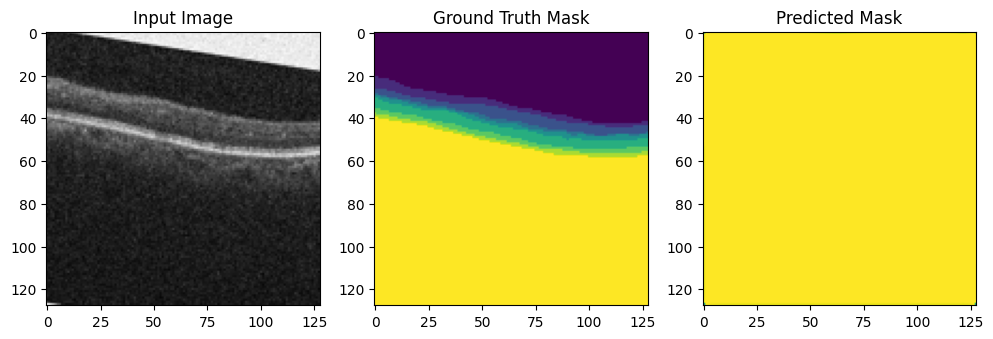

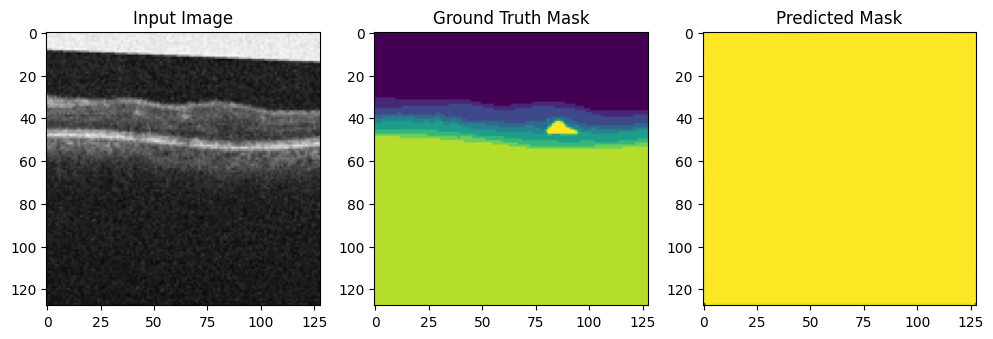

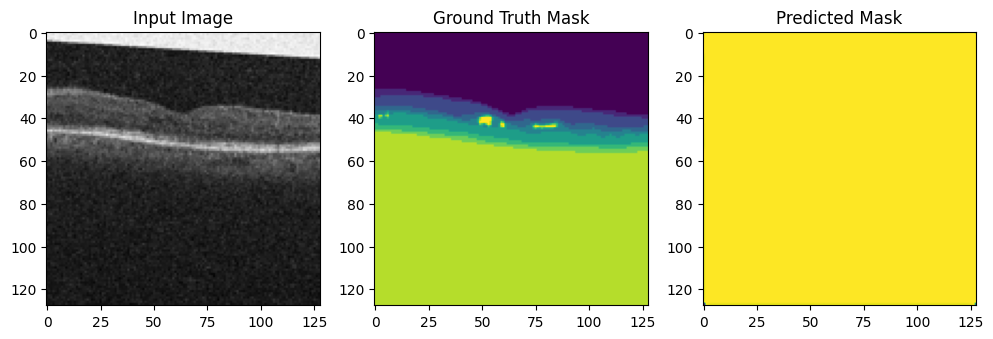

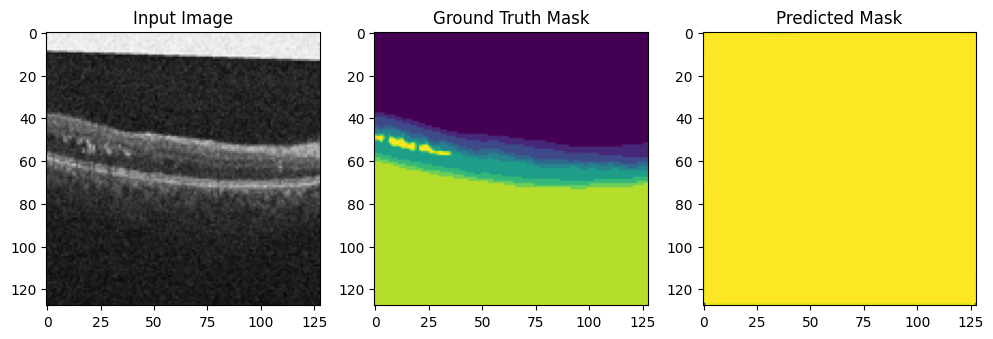

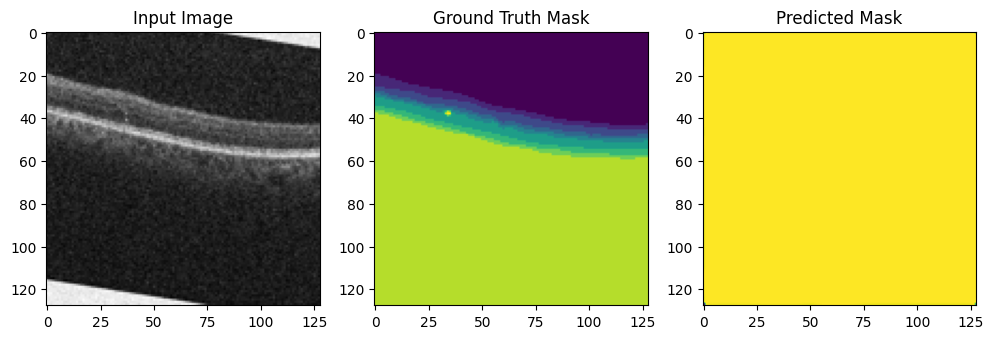

In [20]:


# Optional: Load other components like optimizer, scheduler, etc., if needed
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Ensure the model is in evaluation mode (if needed)
model.eval()

# Create lists to store images, ground truth masks, and predicted masks
images = []
gt_masks = []
pred_masks = []

# Loop through the test dataset and make predictions
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['image']
        masks = batch['mask']

        # Forward pass
        outputs = model(inputs)

        # Convert tensors to numpy arrays
        inputs = inputs.cpu().numpy()
        masks = masks.cpu().numpy()
        outputs = outputs.cpu().numpy()

        # Append to lists
        images.append(inputs)
        gt_masks.append(masks)
        pred_masks.append(outputs)

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
gt_masks = np.concatenate(gt_masks, axis=0)
pred_masks = np.concatenate(pred_masks, axis=0)

# Visualize some results
num_samples_to_visualize = 5

for i in range(num_samples_to_visualize):
    plt.figure(figsize=(12, 4))

    # Plot the input image
    plt.subplot(1, 3, 1)
    plt.imshow(images[i].transpose(1, 2, 0))
    plt.title("Input Image")

    # Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(gt_masks[i][0])
    plt.title("Ground Truth Mask")

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[i][0])
    plt.title("Predicted Mask")

    plt.show()

In [ ]:
#Based on this example: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb
#Based on this example: https://towardsdatascience.com/super-convergence-with-just-pytorch-c223c0fc1e51
#Import Libraries =======================================
from typing import Optional, List
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import albumentations as A
import segmentation_models_pytorch as smp
import rasterio
from sklearn.metrics import confusion_matrix

# Change directory
os.chdir("C:/Maxwell_Data/wvlcDL_2/")

#Read training and testing chip lists =======================================
train = pd.read_csv("C:/Maxwell_Data/wvlcDL_2/wvlcdl_5m/chips/trainSet.csv")
#train2 = train[0:100]
val = pd.read_csv("C:/Maxwell_Data/wvlcDL_2/wvlcdl_5m/chips/valSet.csv")
#val2 = val[0:100]

# Define Variables ========================================
MULTICLASS_MODE: str = "multiclass"
ENCODER = "resnet34"
ENCODER_WEIGHTS = None
CLASSES = [0,1,2,3,4,5,6,7,8,9]
ACTIVATION = None

#Check if GPU is available ===================================
avail = torch.cuda.is_available()
devCnt = torch.cuda.device_count()
devName = torch.cuda.get_device_name(0)
print("Available: " + str(avail) + ", Count: " + str(devCnt) + ", Name: " + str(devName))

# Subclass and define custom dataset ===========================
class MultiClassSegDataset(Dataset):
    
    def __init__(self, df, classes=None, transform=None,):
        self.df = df
        self.classes = classes
        self.transform = transform
    
    def __getitem__(self, idx):
        
        image_name = self.df.iloc[idx, 2]
        mask_name = self.df.iloc[idx, 3]
        source = rasterio.open(image_name)
        image = source.read()
        source.close()
        image = image.astype('uint8')
        image = image.transpose(1,2,0)
        sourceM = rasterio.open(mask_name)
        mask = sourceM.read()
        mask = mask.transpose(1,2,0)
        sourceM.close()
        if(self.transform is not None):
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)   
            image = image.float()/255
            mask = mask.long()
            image = image.permute(2,0,1)
            mask = mask.permute(2,0,1)
        else: 
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.float()/255
            mask = mask.long()
            image = image.permute(2,0,1)
            mask = mask.permute(2,0,1)
        return image, mask  
        
    def __len__(self):
        return len(self.df)

#Define tranforms using Albumations =======================================
val_transform = A.Compose(
    [A.PadIfNeeded(min_height=256, min_width=256, border_mode=4), A.Resize(256, 256),]
)

train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256, border_mode=4),
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

# Create the datasets   ================================================ 
trainDS = MultiClassSegDataset(train, classes=CLASSES, transform=train_transform)
valDS = MultiClassSegDataset(val, classes=CLASSES, transform=val_transform)
print("Number of Training Samples: " + str(len(trainDS)) + " Number of Validation Samples: " + str(len(valDS)))

# Define DataLoaders ==============================================
trainDL = torch.utils.data.DataLoader(trainDS, batch_size=10, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
valDL =  torch.utils.data.DataLoader(valDS, batch_size=10, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

# Check Tensor shapes ======================================================
batch = next(iter(trainDL))
images, labels = batch
print(images.shape, labels.shape, type(images), type(labels), images.dtype, labels.dtype)

# Check first sample from batch =================================================
testImg = images[1]
testMsk = labels[1]
print(testImg.shape, testImg.dtype, type(testImg), testMsk.shape, 
testMsk.dtype, type(testMsk), testImg.min(), 
testImg.max(), testMsk.min(), testMsk.max())

# Plot example image =====================================
plt.imshow(testImg.permute(1,2,0))
plt.show()
plt.close()

# Plot exmaple mask ======================================
plt.imshow(testMsk.permute(1,2,0))
plt.show()
plt.close()

# Define function to calculate overall accuracy and all class precion, recal, and f1 scores from confusion matrix
def my_metrics(cm):
  oa = np.sum(np.diagonal(cm))/np.sum(cm)
  r_1 = cm[0][0]/np.sum(cm[:,0])
  r_2 = cm[1][1]/np.sum(cm[:,1])
  r_3 = cm[2][2]/np.sum(cm[:,2])
  r_4 = cm[3][3]/np.sum(cm[:,3])
  r_5 = cm[4][4]/np.sum(cm[:,4])
  r_6 = cm[5][5]/np.sum(cm[:,5])
  r_7 = cm[6][6]/np.sum(cm[:,6])
  p_1 = cm[0][0]/np.sum(cm[0,:])
  p_2 = cm[1][1]/np.sum(cm[1,:])
  p_3 = cm[2][2]/np.sum(cm[2,:])
  p_4 = cm[3][3]/np.sum(cm[3,:])
  p_5 = cm[4][4]/np.sum(cm[4,:])
  p_6 = cm[5][5]/np.sum(cm[5,:])
  p_7 = cm[6][6]/np.sum(cm[6,:])
  f_1 = (2*r_1*p_1)/(r_1+p_1)
  f_2 = (2*r_2*p_2)/(r_2+p_2)
  f_3 = (2*r_3*p_3)/(r_3+p_3)
  f_4 = (2*r_4*p_4)/(r_4+p_4) 
  f_5 = (2*r_5*p_5)/(r_5+p_5)
  f_6 = (2*r_6*p_6)/(r_6+p_6)
  f_7 = (2*r_7*p_7)/(r_7+p_7)
  met_out = pd.Series([oa, r_1, p_1, f_1, r_2, p_2, f_2, 
  r_3, p_3, f_3, r_4, p_4, f_4, 
  r_5, p_5, f_5, r_6, p_6, f_6, r_7, p_7, f_7], 
  index=["oa", "r_1", "p_1", "f_1", "r_2", "p_2", "f_2", 
  "r_3", "p_3", "f_3", "r_4", "p_4", "f_4", 
  "r_5", "p_5", "f_5", "r_6", "p_6", "f_6", "r_7", "p_7", "f_7"])
  return met_out

# Initiate UNet++ Model ======================================
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    decoder_use_batchnorm=True,
    in_channels=4,
    classes=8,
    activation=ACTIVATION,
).to(torch.device("cuda", 0))

# Define Loss and Metrics to Monitor (Make sure mode = "multiclass") ======================================
criterion = smp.losses.DiceLoss(mode="multiclass", from_logits=True, ignore_index=0)
#loss_fn.__name__ = 'Dice_loss'

# Define Optimizerand learning rate ============================
optimizer = torch.optim.SGD(model.parameters(), lr=2e-3)

# Set up scheduler for One Cycle Learning= ==========================
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-1, epochs=20, steps_per_epoch=len(trainDL))

# Make empty dataframes to save results to ==================================
all_metsTrain = pd.DataFrame(columns=["oa", "r_1", "p_1", "f_1", 
"r_2", "p_2", "f_2", "r_3", "p_3", "f_3", "r_4", "p_4", "f_4", 
"r_5", "p_5", "f_5", "r_6", "p_6", "f_6", "r_7", "p_7", "f_7", "loss"])
all_metsVal = pd.DataFrame(columns=["oa", "r_1", "p_1", "f_1", 
"r_2", "p_2", "f_2", "r_3", "p_3", "f_3", "r_4", "p_4", "f_4", 
"r_5", "p_5", "f_5", "r_6", "p_6", "f_6", "r_7", "p_7", "f_7", "loss"])

# Get number of batches in training set ==========================
size = len(trainDL.dataset)

# Define number of training epochs ========================
epochs = 20

# Define number of batches before applying optimization to update weights ==============
accum_iter = 20

# Define number of classes to differentiate ========================
n_classes = 7

# Define device =============================
device="cuda"

# Loop over epochs for training and validation =====================================
for t in range(epochs):
    # Define empty matrices
    cmTrain = np.zeros([7, 7], dtype=int)
    cmVal = np.zeros([7, 7], dtype=int)
    # Loop through training batches
    for batch_idx, (x_batch, y_batch) in enumerate(trainDL):
        # Send batches to GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.set_grad_enabled(True):
          # Make prediction of data batch
          pred = model(x_batch)
          # Remove prediction for background class
          pred2 = pred[:, 1:n_classes+1, :, :]
          # Return class prediction with highest logit
          pred3 = torch.argmax(pred2, dim=1)
          # Send preddiction to CPU and flatten
          predNP = pred3.detach().cpu().numpy().flatten()
          # Add 1 so that codes match
          predNP = predNP + 1
          # Send reference data to CPU and flatten
          refNP = y_batch.detach().cpu().numpy().flatten()
          # Generate error matrix
          cmTB = confusion_matrix(refNP, predNP, labels=[1,2,3,4,5,6,7])
          # Calculate loss
          lossT = criterion(pred, y_batch)
          # Normalize for accumulation
          lossT = lossT/accum_iter
          #Backpropogate
          lossT.backward()
          # Step for one cycle learning
          scheduler.step()
          # Optimize after only 20 batches
          if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == size):
              optimizer.step()
              optimizer.zero_grad()
          # Add batch to error matrix
          cmTrain += cmTB
          # Same process for validation batches, minus backpropogation and optimization
    for batch_idx, (x_batch, y_batch) in enumerate(valDL):
        with torch.no_grad():
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            pred2 = pred[:, 1:n_classes+1, :, :]
            pred3= torch.argmax(pred2, dim=1)
            predNP = pred3.detach().cpu().numpy().flatten()
            predNP = predNP + 1
            refNP = y_batch.detach().cpu().numpy().flatten()
            cmVB = confusion_matrix(refNP, predNP, labels=[1,2,3,4,5,6,7])
            lossV = criterion(pred, y_batch)
            cmVal += cmVB
    # Use function to calculate metrics
    metsTrain = my_metrics(cmTrain)
    # Append loss to metrics
    metsTrain = metsTrain.append(pd.Series(lossT.detach().cpu().numpy(), index=["loss"]))
    # NA to 0
    metsTrain = metsTrain.fillna(0)
    # Append results to data frame
    all_metsTrain = all_metsTrain.append(metsTrain, ignore_index=True)
    # Repeat for validation data frame
    metsVal = my_metrics(cmVal)
    metsVal = metsVal.append(pd.Series(lossV.detach().cpu().numpy(), index=["loss"]))
    metsVal = metsVal.fillna(0)
    all_metsVal = all_metsVal.append(metsVal, ignore_index=True)
    # Save metrics at end of each epoch
    all_metsTrain.to_csv("train_epoch_metrics.csv")
    all_metsVal.to_csv("val_epoch_metrics.csv")
    # Save model at end of each epoch
    model_name = "model_out_" + str(t) + ".pth"
    torch.save(model.state_dict(), model_name)
    # Print metrics at end of each epoch
    print(f"Epoch {t+1}\nTrain Loss: {lossT}\nVal Loss: {lossV}\nTraining Metrics: {metsTrain}\nVal Metrics: {metsVal}")




